In [118]:
################################
# Random Forest Classification #
################################

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('../data/corpus.csv')

# drop rows where 'Translator' is 'Myst'; drop unnecessary columns
df = df[df['Translator'] != 'Myst']
features = df.drop(['Translator','Work','Chunk', 'Unnamed: 0'], axis=1)
target = df['Translator']

# encoding the labels
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# splits (80-20)
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# instantiate the rfc
classifier = RandomForestClassifier(n_estimators=500, random_state=42)

# fit the model
classifier.fit(X_train, y_train)

# predicting the test set results
y_pred = classifier.predict(X_test)

# evaluate
print("Classification Report: \n", classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# cross validation
cross_val_scores = cross_val_score(classifier, X_train, y_train, cv=5)
print("Cross Validation Scores: ", cross_val_scores)

Classification Report: 
               precision    recall  f1-score   support

        Anon       1.00      1.00      1.00        11
       Arist       1.00      1.00      1.00         7
         Bar       1.00      0.62      0.77         8
         Bur       0.99      1.00      0.99        75
         Jam       0.92      0.75      0.83        16
         Wil       0.96      1.00      0.98       115

    accuracy                           0.97       232
   macro avg       0.98      0.90      0.93       232
weighted avg       0.97      0.97      0.97       232

Accuracy: 96.98%
Cross Validation Scores:  [0.97297297 0.94054054 0.97837838 0.98918919 0.98378378]


In [120]:
# get the classification report and convert to a dict
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

# ... to a df
report_df = pd.DataFrame(report_dict).transpose()

# the 'Support'-column should be an integer, not a float
report_df['support'] = report_df['support'].apply(np.int64)

# normalize 'precision', 'recall' and 'f1-score' columns for same gradient color scheme
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].astype(float)

# rounding the values to two decimal places
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap("{0:.2f}".format)

# apply style
styled_report = report_df.style.background_gradient(subset=['precision', 'recall', 'f1-score'], cmap='Oranges', axis=None)

# save as excel and as latex table
styled_report.to_excel('report.xlsx', engine='openpyxl')

with open('report.tex', 'w') as tf:
    tf.write(report_df.to_latex())

# display
styled_report

/var/folders/qf/gfncxh752lj4x4y55z3b5vnm0000gn/T/ipykernel_28357/3951944584.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


,precision,recall,f1-score,support
Anon,1.00,1.00,1.00,11
Arist,1.00,1.00,1.00,7
Bar,1.00,0.62,0.77,8
Bur,0.99,1.00,0.99,75
Jam,0.92,0.75,0.83,16
Wil,0.96,1.00,0.98,115
accuracy,0.97,0.97,0.97,0
macro avg,0.98,0.90,0.93,232
weighted avg,0.97,0.97,0.97,232


Confusion Matrix: 
 [[ 11   0   0   0   0   0]
 [  0   7   0   0   0   0]
 [  0   0   5   1   1   1]
 [  0   0   0  75   0   0]
 [  0   0   0   0  12   4]
 [  0   0   0   0   0 115]]

Normalized Confusion Matrix: 
 [[1.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.625 0.125 0.125 0.125]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.75  0.25 ]
 [0.    0.    0.    0.    0.    1.   ]]


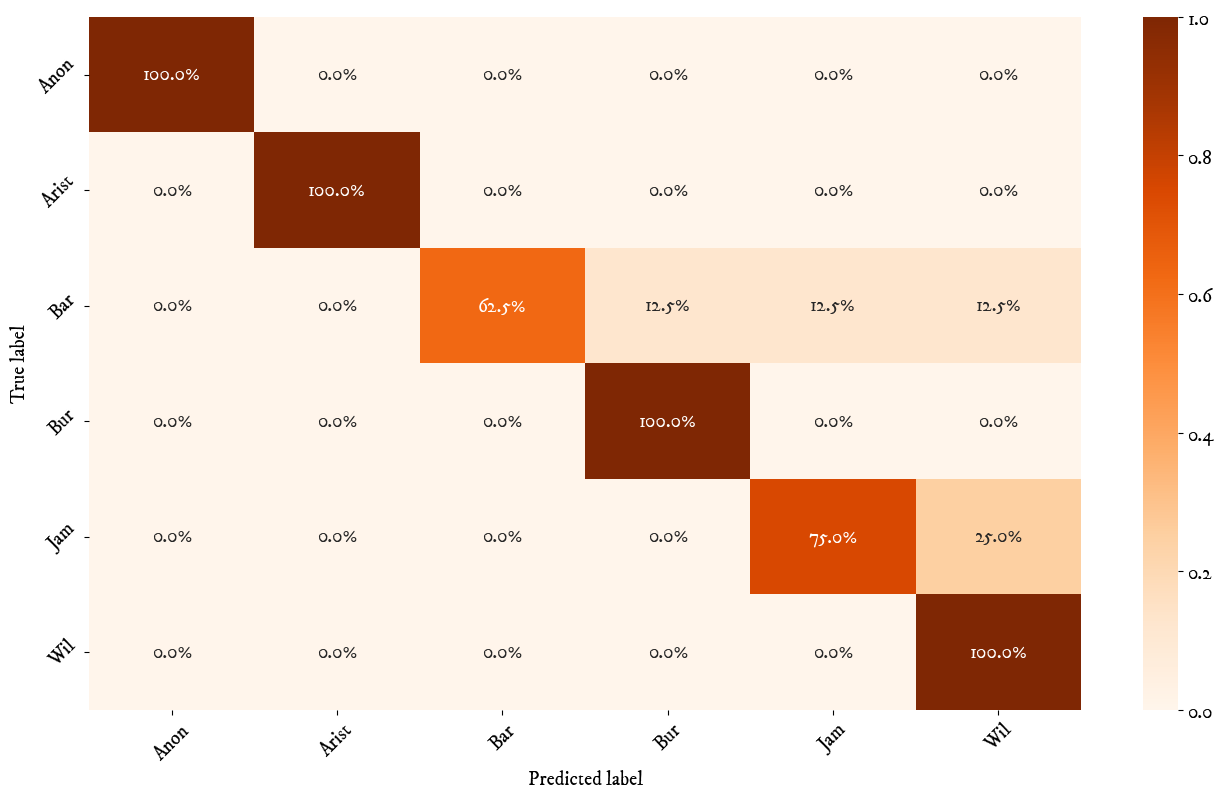

In [121]:
import numpy as np
import seaborn as sns

# displaying the simple confusion matrix (samples)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", conf_matrix)

# create a normalized confusion matrix (percentages)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix: \n", normalized_conf_matrix)

# we want Ben's beatutiful font :)
font_path = '/Users/wouter/Library/Fonts/IMFellDWPica-Regular.ttf'  # Replace with the actual path to the font file
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(normalized_conf_matrix, annot=True, cmap='Oranges', fmt=".1%", xticklabels=le.classes_, yticklabels=le.classes_)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14, rotation=45)
heatmap.set_yticklabels(heatmap.get_xticklabels(), fontsize=14, rotation=45)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Save the plot as a PNG file
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

In [122]:
# this is how visualizing a sigle tree from the random forest usually happens (it's ugly)
# basically: the color of each node in the tree corresponds to the class (i.e. translators) that would be predicted for data points (i.e. text chunks) that fall into that node. 
# the intensity of the color indicates the proportion of samples in that node that belong to the class in question

from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

# select one tree from the forest
chosen_tree = classifier.estimators_[5]

dot_data = tree.export_graphviz(chosen_tree, out_file=None,
                                feature_names=features.columns,  
                                class_names=le.classes_,  
                                filled=True)

# use graphviz to create the graph, specify the size
graph = graphviz.Source(dot_data, format="png")  # Change the values according to your preference

# render the graph
graph.render("ugly_decision_tree")

'ugly_decision_tree.png'

Variable: uero                 Importance: 0.11
Variable: ita                  Importance: 0.09
Variable: rursus               Importance: 0.09
Variable: namque               Importance: 0.07
Variable: quoniam              Importance: 0.06
Variable: sic                  Importance: 0.05
Variable: iterum               Importance: 0.04
Variable: aut                  Importance: 0.03
Variable: autem                Importance: 0.03
Variable: tamquam              Importance: 0.03
Variable: cum                  Importance: 0.02
Variable: denique              Importance: 0.02
Variable: ergo                 Importance: 0.02
Variable: fortassis            Importance: 0.02
Variable: ideo                 Importance: 0.02
Variable: igitur               Importance: 0.02
Variable: nimirum              Importance: 0.02
Variable: quia                 Importance: 0.02
Variable: quod                 Importance: 0.02
Variable: sicut                Importance: 0.02
Variable: ut                   Importanc

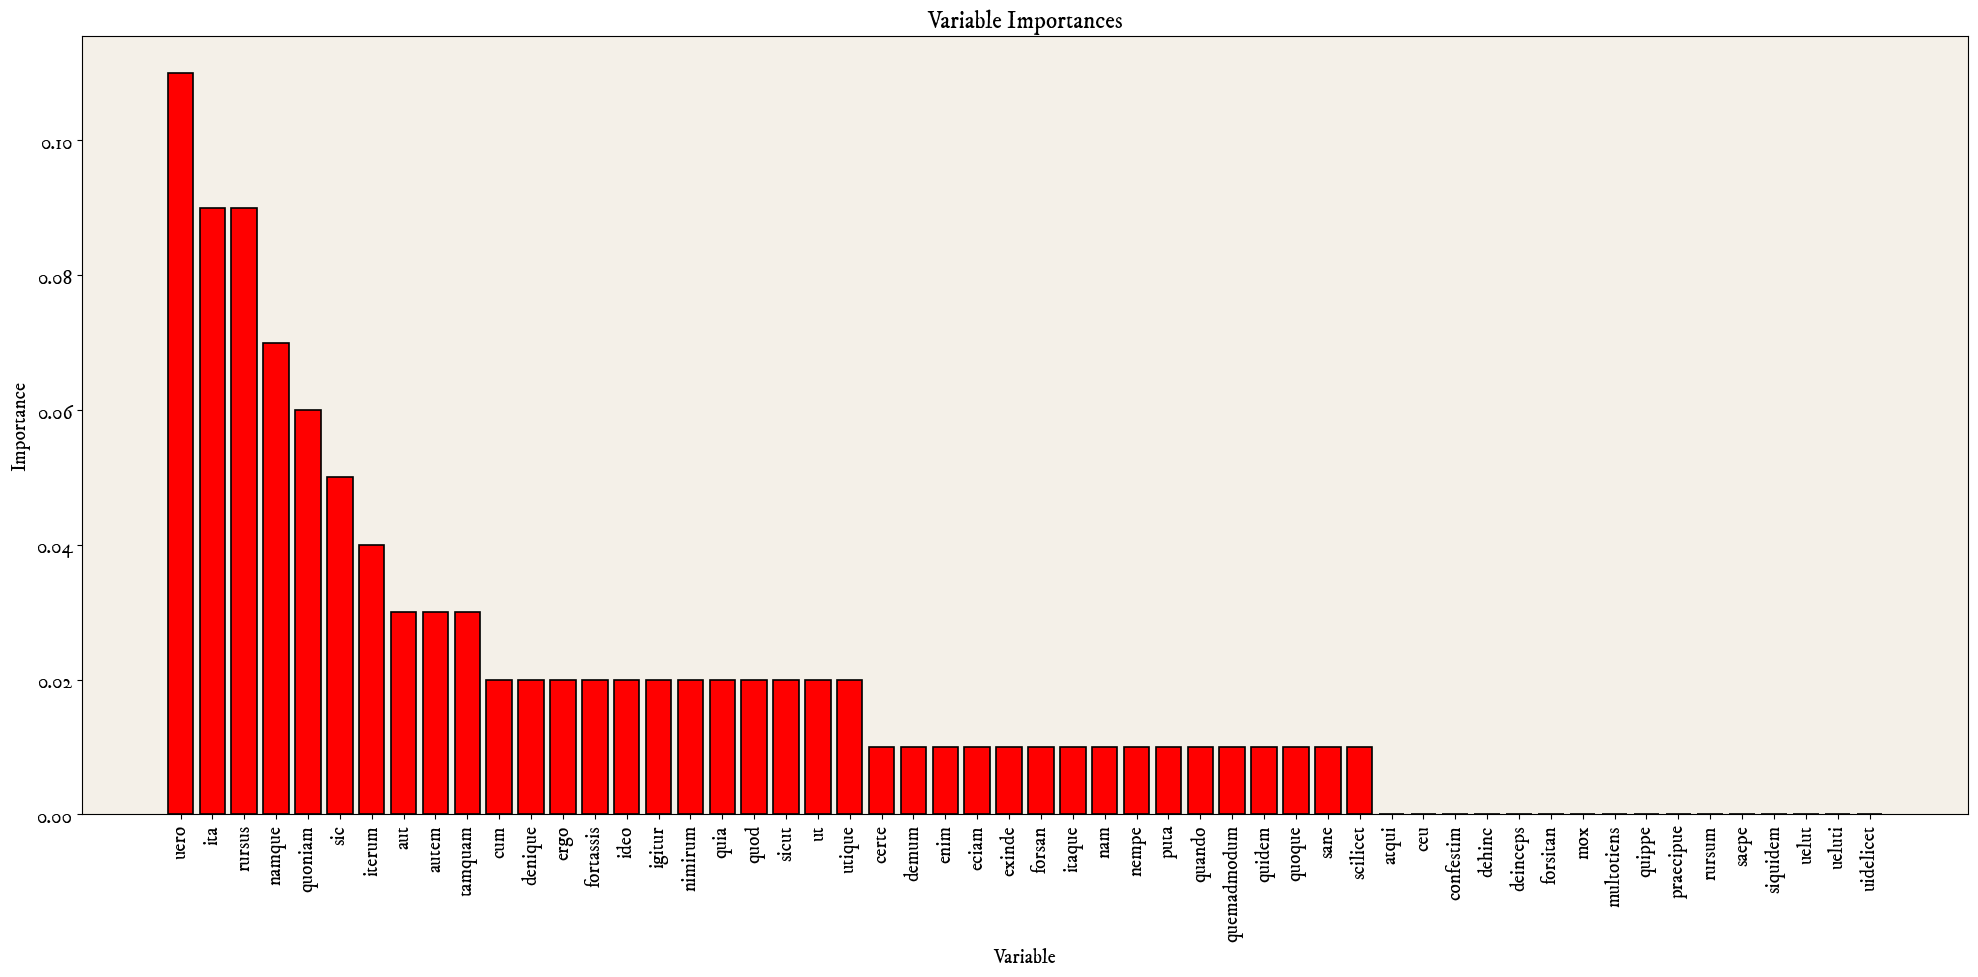

In [123]:
# simple feature imporantance graph (for the sake of sanity)

import matplotlib.pyplot as plt

# get numerical feature importances
importances = list(classifier.feature_importances_)

# list of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# most important feature first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# sort
features_sorted = [item[0] for item in feature_importances]
importances_sorted = [item[1] for item in feature_importances]
x_values = list(range(len(importances_sorted)))

# create fig
fig = plt.figure(figsize=(20,10))

# create bar chart
plt.bar(x_values, importances_sorted, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
plt.rcParams.update({'font.size': 14})
plt.xticks(x_values, features_sorted, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.gca().set_facecolor('#f4f0e8')
plt.tight_layout()
plt.show()

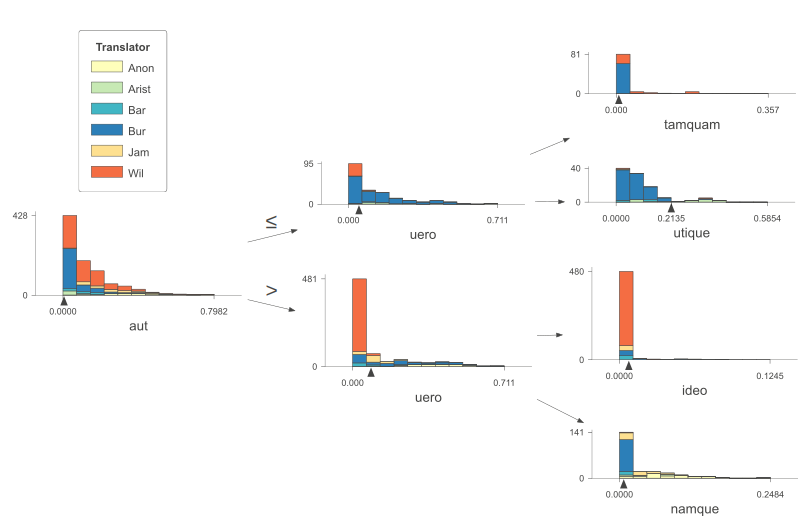

In [124]:
# now a tree visual with dtreeviz!

import dtreeviz

# define the feature and target names
feature_names = features.columns.tolist()
target_name = 'Translator'
class_names = le.classes_.tolist()

viz_model = dtreeviz.model(classifier.estimators_[5],
                           X_train,
                           y_train,
                           feature_names=feature_names,
                           target_name=target_name,
                           class_names=class_names)

v = viz_model.view(depth_range_to_display=[0,2], scale=1.5, orientation='LR') # pass orientation here (add: depth_range_to_display=[0,2])
v.save("decision_tree_example.svg")  # optionally save as svg
v

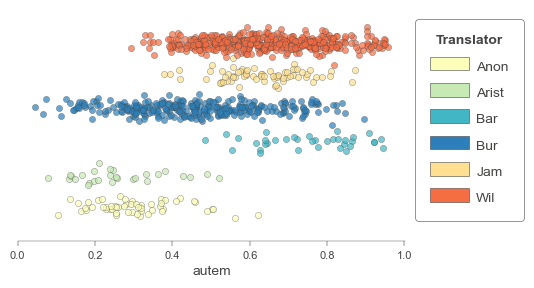

In [125]:
viz_model.ctree_feature_space(features=['autem'], show={'legend'}, figsize=(5,3))